In [178]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from enum import Enum

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [179]:
EXPORTS_DIR = '../data/exports'
MATRIX_DIR = '../data/exports/adjacency_matrix'
SHAPEFILE_DIR = '../data/shapefiles/zipcodes'
CENTROIDS_DIR = '../data/exports'
LABELS_DIR = '../data/exports'
CLUSTER = True
K = 25
NODE_TYPE = 'station_id'

if CLUSTER:
    MATRIX_DIR = f'{MATRIX_DIR}/k{K}'
    NODE_TYPE = 'label'


class AnalysisConfig:
    def __init__(self, shapefile_path='', stations_path='', city_suffix=''):
        self.shapefile_path = shapefile_path
        self.stations_path = stations_path
        self.centroids_path = (
            f'{CENTROIDS_DIR}/centroids_k25_{city_suffix}.csv')
        self.labels_path = (
            f'{LABELS_DIR}/cluster_labels_k25_{city_suffix}.csv')
        self.displacement_matrix_path = (
            f'{MATRIX_DIR}/displacement_{city_suffix}.csv')
        self.elevation_matrix_path = (
            f'{MATRIX_DIR}/elevation_{city_suffix}.csv')
        self.trip_count_classic_matrix_path = (
            f'{MATRIX_DIR}/trip_count_classic_{city_suffix}.csv')
        self.trip_count_electric_matrix_path = (
            f'{MATRIX_DIR}/trip_count_electric_{city_suffix}.csv')
        self.trip_count_matrix_path = (
            f'{MATRIX_DIR}/trip_count_{city_suffix}.csv')
        self.city_suffix = city_suffix

    def get_export_path(self, filename):
        return f'{EXPORTS_DIR}/{filename}_{self.city_suffix}.csv'
    
    def get_nodes_df(self):
        if CLUSTER:
            return pd.read_csv(self.centroids_path).reset_index().rename(columns={
                'index': 'label',
            })
        return pd.read_csv(self.stations_path)


def get_trip_matrix(config, path=None):
    if not path:
        path = config.trip_count_matrix_path
    trip_matrix = pd.read_csv(path, index_col=0)
    trip_matrix.columns = trip_matrix.columns.astype('str')
    trip_matrix.index = trip_matrix.index.astype('str')
    return trip_matrix

In [180]:
config_sf = AnalysisConfig(
    city_suffix = 'sf',
    shapefile_path = f'{SHAPEFILE_DIR}/san_francisco.shp',
    stations_path = f'{STATIONS_DIR}/SF_ele_single station.csv',
)

config_dc = AnalysisConfig(
    city_suffix = 'dc',
    shapefile_path = f'{SHAPEFILE_DIR}/washington_dc.shp',
    stations_path = f'{STATIONS_DIR}/DC_ele_single station.csv',
)

In [181]:
config = config_sf

In [225]:
def load_gdfs(config):
    zips_gdf = gpd.read_file(config.shapefile_path)
    nodes_df = config.get_nodes_df()
    nodes_gdf = gpd.GeoDataFrame(
        nodes_df,
        geometry=gpd.points_from_xy(nodes_df['lng'],
                                    nodes_df['lat'])).set_crs('EPSG:4326')
    nodes_gdf[NODE_TYPE] = nodes_gdf[NODE_TYPE].astype('str')
    return (zips_gdf, nodes_gdf)

In [183]:
zips_gdf, nodes_gdf, = load_gdfs(config)

,label,lat,lng,elevation,count
0,0,37.781587,-122.473112,49.111111,9
1,1,37.773834,-122.398586,4.354839,31
2,2,37.757350,-122.417521,21.142857,14
3,3,37.782258,-122.437804,69.000000,8
4,4,37.731755,-122.393808,20.375000,8
5,5,37.785223,-122.426924,40.888889,9
6,6,37.794455,-122.396477,3.700000,20
7,7,37.722559,-122.451952,63.250000,4
8,8,37.721483,-122.480770,35.500000,2
9,9,37.736178,-122.454438,106.500000,4


In [193]:
def normalize_matrix(matrix, max=max):
    return matrix.div(max)

In [185]:
labels_df = pd.read_csv(config.labels_path, index_col=0)
display(labels_df)

,label
station_id,
SF-M26,22
SF-M25,22
SF-M26-2,1
SF-L27,1
SF-K26,1
...,...
SF-Z16,7
SF-Y14,9
SF-X14,9


In [186]:
def get_lat_lng(df, node_id):
    return df[df[NODE_TYPE] == node_id][[
        'lat', 'lng'
    ]].iloc[0][:]

def get_lat_lng_edges(matrix, nodes_gdf=nodes_gdf):
    node_ids = list(matrix.columns)
    display(matrix)
    
    def has_node(id):
        return len(nodes_gdf[nodes_gdf[NODE_TYPE] == id]) > 0
    
    edges = pd.DataFrame([], columns=['lat1', 'lng1', 'lat2', 'lng2', 'value'])
    for id1 in node_ids:
        if not has_node(id1):
            continue
            
        lat1, lng1 = get_lat_lng(nodes_gdf, id1)
        
        for id2 in node_ids:
            if id1 == id2 or not has_node(id2):
                continue
                
            lat2, lng2 = get_lat_lng(nodes_gdf, id2)

            edges = edges.append({
                'lat1': lat1,
                'lng1': lng1,
                'lat2': lat2,
                'lng2': lng2,
                'value': matrix[id1][id2],
            }, ignore_index=True)
            
    return edges

In [210]:
def get_sorted_edges(trip_matrix_norm):
    edges = get_lat_lng_edges(trip_matrix_norm)
    sorted_edges = edges[edges['value'] > 0].sort_values(by='value')
    sorted_edges['value'] = sorted_edges['value'] / sorted_edges['value'].max()
    return sorted_edges

In [211]:
trip_matrix_all = get_trip_matrix(config, config.trip_count_matrix_path)
trip_max = trip_matrix_all.max().max()
trip_matrix_all = normalize_matrix(trip_matrix_all, max=trip_max)
edges_all = get_sorted_edges(trip_matrix_all)

trip_matrix_classic = get_trip_matrix(config, config.trip_count_classic_matrix_path)
trip_matrix_classic = normalize_matrix(trip_matrix_classic, max=trip_max)
edges_classic = get_sorted_edges(trip_matrix_classic)

trip_matrix_electric = get_trip_matrix(config, config.trip_count_electric_matrix_path)
trip_matrix_electric = normalize_matrix(trip_matrix_electric, max=trip_max)
edges_electric = get_sorted_edges(trip_matrix_electric)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
label,,,,,,,,,,,,,,,,,,,,,
0,0.127252,0.004580,0.010101,0.022985,0.000043,0.009887,0.006848,0.000171,0.000086,0.000428,...,0.007276,0.000514,0.000984,0.030561,0.033386,0.020674,0.081882,0.012712,0.014639,0.007405
1,0.004922,1.000000,0.185892,0.031203,0.009973,0.079271,0.392587,0.000642,0.000000,0.000984,...,0.084022,0.198091,0.013140,0.079570,0.020331,0.001926,0.024012,0.363310,0.095364,0.364037
2,0.010101,0.197235,0.311561,0.041390,0.007747,0.037452,0.047297,0.002782,0.000342,0.003895,...,0.021187,0.058725,0.032059,0.093010,0.031546,0.002782,0.042203,0.256174,0.113384,0.094080
3,0.025938,0.050550,0.051406,0.122673,0.000043,0.044301,0.041818,0.000428,0.000171,0.000514,...,0.025382,0.005907,0.003638,0.082181,0.055729,0.011000,0.088002,0.051877,0.047896,0.056628
4,0.000086,0.013183,0.004237,0.000257,0.014082,0.001241,0.002440,0.000086,0.000000,0.000000,...,0.000685,0.005265,0.000685,0.000428,0.000128,0.000000,0.000128,0.003253,0.001883,0.001841
5,0.013611,0.114668,0.053375,0.036425,0.001455,0.134657,0.089072,0.000128,0.000000,0.000770,...,0.039036,0.012370,0.003724,0.088216,0.020588,0.003595,0.032530,0.096435,0.061850,0.121260
6,0.005736,0.374995,0.044729,0.024269,0.001926,0.057826,0.777297,0.000257,0.000043,0.000942,...,0.116851,0.088345,0.004409,0.043017,0.011214,0.004623,0.011557,0.106450,0.048667,0.281514
7,0.000086,0.000813,0.003125,0.000086,0.000556,0.000086,0.000128,0.015537,0.000942,0.001198,...,0.000043,0.000385,0.001712,0.000342,0.000813,0.000000,0.000599,0.000813,0.000642,0.000514
8,0.000000,0.000000,0.000385,0.000086,0.000000,0.000000,0.000000,0.000514,0.008732,0.000171,...,0.000000,0.000043,0.000128,0.000300,0.000128,0.000171,0.000128,0.000043,0.000043,0.000000


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
label,,,,,,,,,,,,,,,,,,,,,
0,0.070325,0.000556,0.001841,0.003553,0.000043,0.002654,0.000813,0.000000,0.000043,0.000000,...,0.000728,0.000128,0.000171,0.007961,0.009331,0.008689,0.036853,0.002739,0.004580,0.001327
1,0.000770,0.607627,0.061251,0.007234,0.004494,0.016137,0.241407,0.000000,0.000000,0.000086,...,0.027950,0.110089,0.000942,0.016907,0.003253,0.000642,0.004965,0.184779,0.024868,0.178188
2,0.000685,0.066173,0.162394,0.005222,0.001198,0.006463,0.020117,0.000385,0.000086,0.000128,...,0.005051,0.023113,0.006206,0.018662,0.005222,0.001027,0.015067,0.137611,0.036725,0.037966
3,0.006634,0.023285,0.014810,0.053418,0.000000,0.015837,0.014981,0.000171,0.000086,0.000000,...,0.006934,0.001498,0.000342,0.031760,0.011728,0.004237,0.035441,0.017892,0.019860,0.018320
4,0.000000,0.003724,0.000728,0.000043,0.005821,0.000813,0.000342,0.000043,0.000000,0.000000,...,0.000128,0.000770,0.000128,0.000086,0.000043,0.000000,0.000000,0.000899,0.000171,0.000300
5,0.002483,0.050165,0.013611,0.005950,0.000856,0.054573,0.036382,0.000000,0.000000,0.000000,...,0.011471,0.003167,0.000599,0.024740,0.002825,0.000942,0.008090,0.043659,0.024098,0.057270
6,0.000942,0.224671,0.015709,0.002055,0.000685,0.010230,0.588666,0.000086,0.000000,0.000086,...,0.059367,0.043830,0.000856,0.007662,0.000642,0.000385,0.001669,0.043359,0.010658,0.174721
7,0.000000,0.000128,0.001156,0.000043,0.000214,0.000000,0.000128,0.009631,0.000428,0.000471,...,0.000043,0.000257,0.000300,0.000086,0.000086,0.000000,0.000171,0.000514,0.000128,0.000214
8,0.000000,0.000000,0.000086,0.000000,0.000000,0.000000,0.000000,0.000385,0.006206,0.000128,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000043,0.000000,0.000000,0.000000


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
label,,,,,,,,,,,,,,,,,,,,,
0,0.056928,0.004023,0.008261,0.019432,0.000000,0.007234,0.006035,0.000171,0.000043,0.000428,...,0.006549,0.000385,0.000813,0.022600,0.024055,0.011985,0.045028,0.009973,0.010059,0.006078
1,0.004152,0.392373,0.124642,0.023970,0.005479,0.063134,0.151179,0.000642,0.000000,0.000899,...,0.056072,0.088002,0.012199,0.062663,0.017078,0.001284,0.019047,0.178530,0.070496,0.185849
2,0.009417,0.131062,0.149167,0.036168,0.006549,0.030989,0.027180,0.002397,0.000257,0.003767,...,0.016137,0.035612,0.025853,0.074348,0.026324,0.001755,0.027137,0.118564,0.076660,0.056114
3,0.019304,0.027265,0.036596,0.069255,0.000043,0.028464,0.026837,0.000257,0.000086,0.000514,...,0.018448,0.004409,0.003296,0.050422,0.044001,0.006763,0.052562,0.033985,0.028036,0.038308
4,0.000086,0.009459,0.003510,0.000214,0.008261,0.000428,0.002097,0.000043,0.000000,0.000000,...,0.000556,0.004494,0.000556,0.000342,0.000086,0.000000,0.000128,0.002354,0.001712,0.001541
5,0.011129,0.064504,0.039764,0.030476,0.000599,0.080084,0.052690,0.000128,0.000000,0.000770,...,0.027565,0.009203,0.003125,0.063476,0.017763,0.002654,0.024440,0.052776,0.037752,0.063990
6,0.004794,0.150323,0.029020,0.022215,0.001241,0.047597,0.188632,0.000171,0.000043,0.000856,...,0.057484,0.044515,0.003553,0.035355,0.010572,0.004237,0.009887,0.063091,0.038009,0.106793
7,0.000086,0.000685,0.001969,0.000043,0.000342,0.000086,0.000000,0.005907,0.000514,0.000728,...,0.000000,0.000128,0.001412,0.000257,0.000728,0.000000,0.000428,0.000300,0.000514,0.000300
8,0.000000,0.000000,0.000300,0.000086,0.000000,0.000000,0.000000,0.000128,0.002525,0.000043,...,0.000000,0.000043,0.000128,0.000300,0.000128,0.000171,0.000086,0.000043,0.000043,0.000000


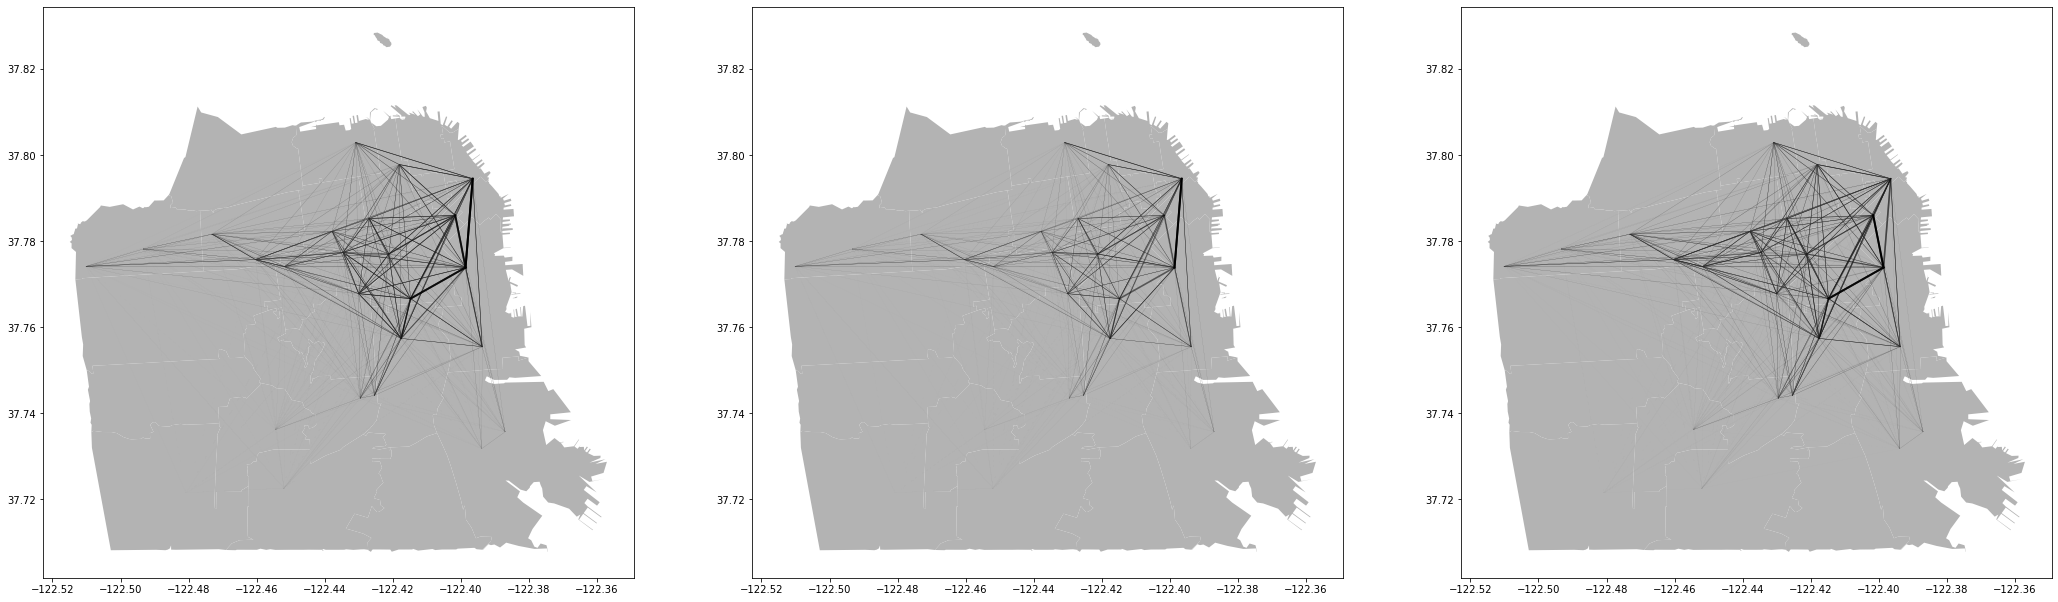

In [226]:
CRS_PLOT = 'EPSG:4326'

def plot_map(fig, ax, zips_gdf):
    zips_gdf.to_crs({'init': CRS_PLOT}).plot(ax=ax, color=str(0.7), zorder=0)
    
def plot_network(fig, ax, edges, title=''):
    for i, edge in edges.iterrows():
        lat1, lng1, lat2, lng2 = edge[['lat1', 'lng1', 'lat2', 'lng2']]
        # 0.0 = black, 1.0 = white, flip and scale to [0.0, 0.5].
        color = (1 - edge['value']) * 0.25
        alpha = max(edge['value'] * 3, 1)
        linewidth = edge['value'] * 2
        ax.plot([lng1, lng2], [lat1, lat2],
                 'k-',
                 linewidth=linewidth,
                 color=str(color),
                 alpha=alpha,
                 zorder=1)

    ax.set_title(title)

fig, ax = plt.subplots(1, 3, figsize=(36, 12))
edges_list = [edges_all, edges_classic, edges_electric]

for i in range(0, 3):
    plot_map(fig, ax[i], zips_gdf)
    plot_network(fig, ax[i], edges_list[i])

plt.show()

In [227]:
def get_flow_df(matrix_path):
    matrix = pd.read_csv(matrix_path).set_index(NODE_TYPE)
    matrix.columns = matrix.columns.astype('str')
    matrix.index = matrix.index.astype('str')
    in_counts = matrix.sum(numeric_only=True)
    out_counts = matrix.sum(axis=1)
    matrix['in'] = in_counts
    matrix['out'] = out_counts
    matrix['diff'] = in_counts - out_counts
    return matrix[['in', 'out', 'diff']]

def get_normalized_column(df, column):
    column_min = df[column].min()
    return (df[column] - column_min) / (df[column].max() - column_min)

def normalize_flow_df(df):
    normalized_df = df.copy()
    normalized_df['in'] = get_normalized_column(df, 'in')
    normalized_df['out'] = get_normalized_column(df, 'out')
    normalized_df['diff'] = get_normalized_column(df, 'diff')
    return normalized_df

trip_flow_df = get_flow_df(config.trip_count_matrix_path)

In [228]:
zips_gdf, nodes_gdf = load_gdfs(config)
nodes_flow_gdf = pd.merge(nodes_gdf, trip_flow_df, on=NODE_TYPE)
nodes_gdf['count'] = (nodes_gdf['count'] - nodes_gdf['count'].min()) / (nodes_gdf['count'].max() - nodes_gdf['count'].min())

In [255]:
def plot_nodes(fig, ax, nodes_gdf, column, title, top_n=None, bottom_n=None, outline=False, colormap='coolwarm_r'):
    all_gdf = nodes_gdf.to_crs({'init': CRS_PLOT}).copy()
    
    gdfs = []
    if top_n or bottom_n:
        all_gdf = all_gdf.sort_values([column], ascending=False)
        if top_n:
            gdfs.append(all_gdf.iloc[0:top_n, :])
        if bottom_n:
            gdfs.append(all_gdf.iloc[-bottom_n:, :])
    else:
        gdfs.append(all_gdf)
        
    gdf = pd.concat(gdfs)
    markersize = nodes_gdf['count'] * 150 + 50
    if outline == False:
        gdf.plot(ax=ax,
                 column=column,
                 norm=matplotlib.colors.Normalize(),
                 cmap=colormap,
                 edgecolors='black',
                 markersize=markersize,
                 zorder=2)
    else:
        gdf.plot(ax=ax,
                 column=column,
                 norm=matplotlib.colors.Normalize(),
                 cmap='coolwarm',
                 edgecolors='black',
                 markersize=markersize * 2,
                 zorder=2)
    ax.set_title(title)
    
    return fig, ax

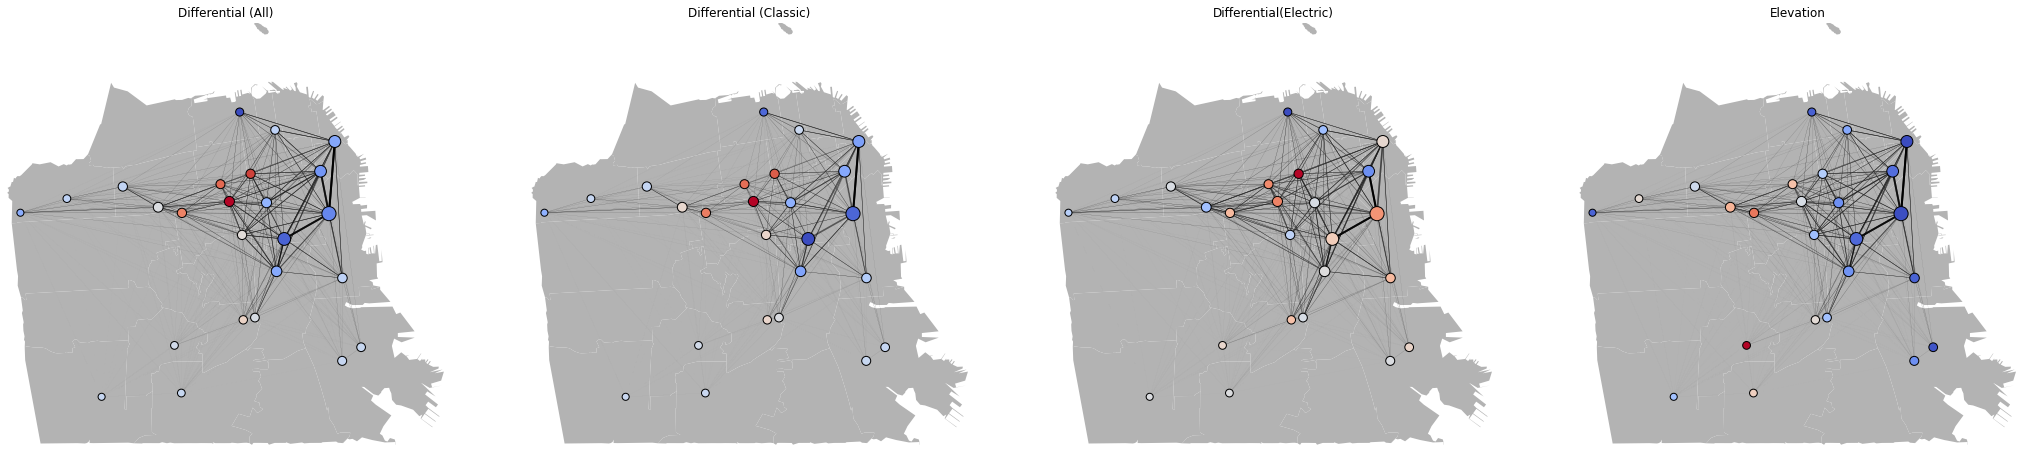

In [256]:
fig, ax = plt.subplots(1, 4, figsize=(36, 20))
edges_list = [edges_all, edges_classic, edges_electric]
titles = ['Differential (All)', 'Differential (Classic)', 'Differential(Electric)']

trip_flow_dfs = [
    get_flow_df(config.trip_count_matrix_path),
    get_flow_df(config.trip_count_classic_matrix_path),
    get_flow_df(config.trip_count_electric_matrix_path),
]

zips_gdf, nodes_gdf = load_gdfs(config)
nodes_gdf['count'] = (nodes_gdf['count'] - nodes_gdf['count'].min()) / (nodes_gdf['count'].max() - nodes_gdf['count'].min())
nodes_flow_gdfs = [
    pd.merge(nodes_gdf, df, on=NODE_TYPE) for df in trip_flow_dfs]


for i in range(0, 3):
    plot_map(fig, ax[i], zips_gdf)
    plot_network(fig, ax[i], edges_list[i])
    plot_nodes(fig, ax[i], nodes_flow_gdfs[i], 'diff', title=titles[i])
    
plot_map(fig, ax[3], zips_gdf)
plot_network(fig, ax[3], edges_list[0])
plot_nodes(fig, ax[3], nodes_flow_gdfs[0], 'elevation', title='Elevation', colormap='coolwarm')
    
for i in range(0, 4):
    ax[i].axis('off')
    ax[i].margins(0)
    ax[i].apply_aspect()

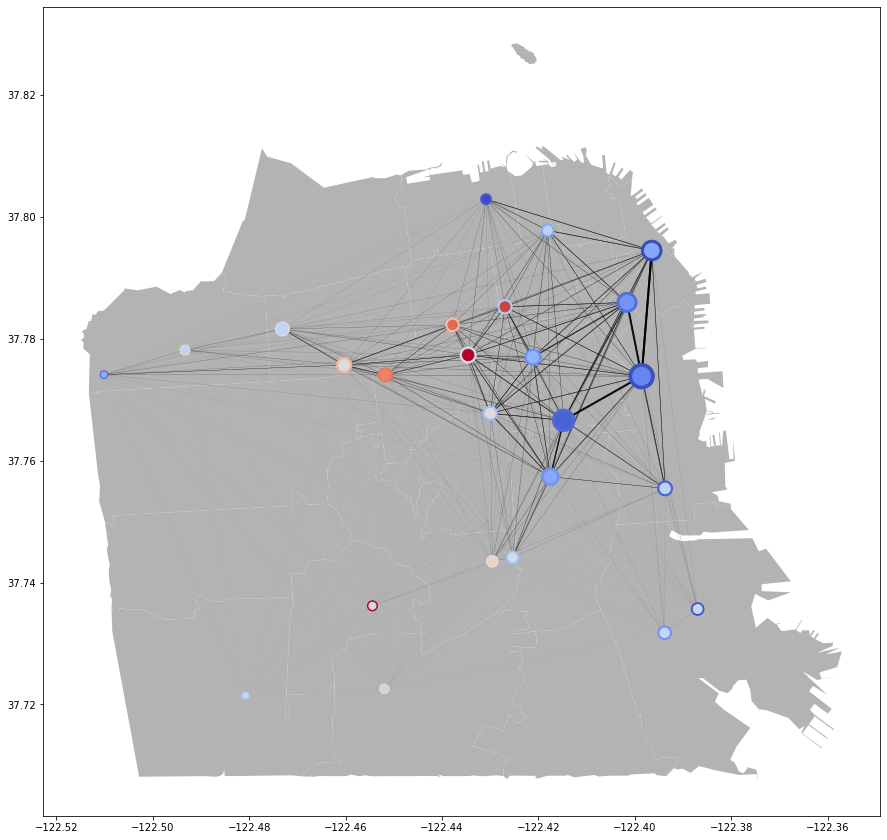

In [176]:
nodes_flow_gdf_norm =  nodes_flow_gdf
nodes_flow_gdf_norm['elevation'] =  nodes_flow_gdf_norm['elevation'] / nodes_flow_gdf_norm['elevation'].max()
nodes_flow_gdf_norm['diff'] =  nodes_flow_gdf_norm['diff'] / nodes_flow_gdf_norm['diff'].max()

fig, ax = plt.subplots(figsize=(15, 15))
plot_map(fig, ax, zips_gdf)
plot_network(fig, ax, sorted_edges[-N:])
plot_nodes(fig, ax, nodes_flow_gdf_norm, 'elevation', '', outline=True)
plot_nodes(fig, ax, nodes_flow_gdf_norm, 'diff', '')
plt.show()

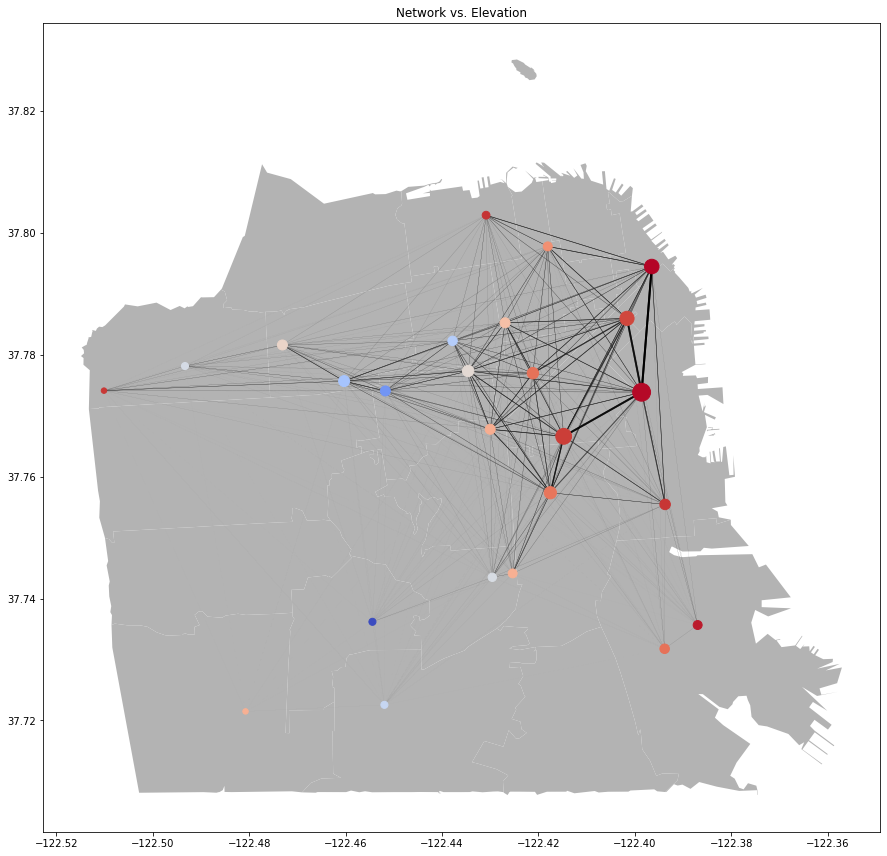

In [162]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_map(fig, ax, zips_gdf)
plot_network(fig, ax, sorted_edges[-N:])
plot_nodes(fig, ax, nodes_flow_gdf, 'elevation', 'Network vs. Elevation')
plt.show()

In [157]:
from enum import Enum

class Segment(Enum):
    ALL = 0
    CLASSIC = 1
    ELECTRIC = 2

class Analysis:
    def __init__(self, config, segment):
        self.config = config
        self.segment = segment
        
    def analyze(self):
        trip_matrix = get_trip_matrix(self.config, self.get_trip_count_matrix_path())
        trip_matrix = normalize_matrix(trip_matrix)
        self.trip_matrix = trip_matrix
        
        trip_flow_df = get_flow_df(self.get_trip_count_matrix_path())
        self.zips_gdf, self.stations_gdf = load_gdfs(self.config)
        self.stations_flow_gdf = pd.merge(self.stations_gdf, trip_flow_df, on='station_id')
        
        edges = get_lat_lng_edges(trip_matrix, self.stations_flow_gdf)
        edges = edges[edges['value'] > 0].sort_values(by='value')
        edges['value'] = edges['value'] / edges['value'].max()
        self.edges = edges
        
    def plot(self, fig, ax, variable=None, N=5000, top_n=None, bottom_n=None):
        plot_map(fig, ax, self.zips_gdf)
        plot_network(fig, ax, self.stations_gdf, self.edges[-N:])
        
        if variable:
            plot_stations(fig, ax, self.stations_flow_gdf, variable, self.get_plot_label(), top_n=top_n, bottom_n=bottom_n)
            
        ax.set_xticks([])
        ax.set_yticks([])
        
    def get_plot_label(self):
        if self.segment == Segment.ALL:
            return 'All'
        elif self.segment == Segment.CLASSIC:
            return 'Classic'
        elif self.segment == Segment.ELECTRIC:
            return 'Electric'
        return None
        
    def get_trip_count_matrix_path(self):
        if self.segment == Segment.ALL:
            return self.config.trip_count_matrix_path
        elif self.segment == Segment.CLASSIC:
            return self.config.trip_count_classic_matrix_path
        elif self.segment == Segment.ELECTRIC:
            return self.config.trip_count_electric_matrix_path
        return None

In [ ]:
config = config_sf
analyses = [Analysis(config, s) for s in [Segment.CLASSIC, Segment.ELECTRIC]]

for analysis in analyses:
    analysis.analyze()

In [ ]:
fig, ax = plt.subplots(1, len(analyses), figsize=(30, 15))
for i in range(0, len(analyses)):
    analyses[i].plot(fig, ax[i])

plt.show()

In [ ]:
fig, ax = plt.subplots(1, len(analyses), figsize=(30, 15))
for i in range(0, len(analyses)):
    analyses[i].plot(fig, ax[i], 'diff', N=100, top_n=20, bottom_n=20)
    
fig.colorbar(im, ax=ax.ravel().tolist())
plt.show()

In [ ]:
def get_trips_from_matrix(matrix):
    station_ids = list(matrix.columns)
    data = []
    for id1 in station_ids:
        for id2 in station_ids:
            if id1 != id2:
                data.append({
                    'station_id1': id1,
                    'station_id2': id2,
                    'value': matrix[id1][id2],
                })
    return pd.DataFrame(data)

trip_matrix = get_trip_matrix(config)
trips_df = get_trips_from_matrix(trip_matrix)

a = analyses[0]
trip_matrix = get_trip_matrix(a.config, a.config.trip_count_classic_matrix_path)
trips_classic_df = get_trips_from_matrix(trip_matrix)

a = analyses[1]
trip_matrix = get_trip_matrix(a.config, a.config.trip_count_electric_matrix_path)
trips_electric_df = get_trips_from_matrix(trip_matrix)

merged_df = pd.merge(trips_df, trips_classic_df, on=['station_id1', 'station_id2'])
merged_df = pd.merge(merged_df, trips_electric_df, on=['station_id1', 'station_id2'])

trip_ratios_df = merged_df.rename(columns={
    'value_x': 'all',
    'value_y': 'classic',
    'value': 'electric',
})
trip_ratios_df = trip_ratios_df[trip_ratios_df['all'] > 0]

trip_ratios_df['classic_ratio'] = trip_ratios_df['classic'] / trip_ratios_df['all']
trip_ratios_df['electric_ratio'] = trip_ratios_df['electric'] / trip_ratios_df['all']

display(trip_ratios_df)


In [ ]:
elevation_matrix_path = '{}/elevation_sf.csv'.format(MATRIX_DIR)
elevation_matrix = get_trip_matrix(config, elevation_matrix_path)
elevation_df = get_trips_from_matrix(elevation_matrix)

displacement_matrix_path = '{}/displacement_sf.csv'.format(MATRIX_DIR)
displacement_matrix = get_trip_matrix(config, displacement_matrix_path)
displacement_df = get_trips_from_matrix(displacement_matrix)

combined_trip_ratios_df = pd.merge(trip_ratios_df, elevation_df, on=['station_id1', 'station_id2'], how='left').rename(columns={'value': 'elevation_change'})
combined_trip_ratios_df = pd.merge(combined_trip_ratios_df, displacement_df, on=['station_id1', 'station_id2'], how='left').rename(columns={'value': 'displacement'})
combined_trip_ratios_df = combined_trip_ratios_df.sort_values(['all'], ascending=False)

display(combined_trip_ratios_df)

In [ ]:
export_df = combined_trip_ratios_df.drop(['classic_ratio', 'electric_ratio'], axis=1)
display(export_df)
export_df.to_csv('../data/exports/aggregated_trips_sf.csv', )